## Project 5: Estimating a Hidden Markov Model (HMM)
#### CSC 591 - IoTA Fall 2016
##### Unity ID: avshirod (Aditya Shirode)

In [1]:
# Required imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm, base
import sklearn.preprocessing as pp
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from tabulate import tabulate
import math
import sklearn.metrics as sm
import statsmodels.api as sta
from statsmodels.tsa.ar_model import AR
%matplotlib inline
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 15, 8
np.random.seed(42)

In [2]:
# Reading in Data and Splitting for Training-Testing
# 2000 Obs = 1600 Train + 400 Test
filename = 'data_avshirod.csv'
data = pd.read_csv(filename, header=None)
train = data[:1600]
test = data[1600:]

Number of states for Markov Model is *3*.
The set of observations is {1,2,3,4,5}.

In [3]:
states = [0,1,2]
observations = [1,2,3,4,5]
seq = list(train[0])

### Task 1 - Develop a Hidden Markov Model

Use an HMM solver to estimate the HMM parameters P=(pij), π, and B=(bik). Give your results in one or more tables.

Run the model to predict the next 400 observations, and compare the HMM results to thetraining data set and compute the sum of squared errors (SSE), the root mean squared error, and R2. Use existing functions to carry out both tasks. Give all your results in a table.

In [4]:
# Enconding data from 1--5 to 0--4 as required by the HMMLearn package
# Transforming data into 1600*1 Column Matrix for computation
labels = pp.LabelEncoder()
data_mod = labels.fit_transform(data).reshape(-1, 1)
train_mod = labels.fit_transform(train).reshape(-1, 1)
test_mod = labels.fit_transform(test).reshape(-1, 1)

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# Ref: https://jyyuan.wordpress.com/2014/01/28/baum-welch-algorithm-finding-parameters-for-our-hmm/
prob_eq = [1/len(observations)] * len(observations)
state_change_prob = 1/len(states)
state_change_prob_eq = [state_change_prob] * len(states) 
A = np.array([[state_change_prob_eq] * len(states)])
# A = np.array([[0.25, 0.45, 0.3],
#               [0.5, 0.3, 0.2],
#               [0.4, 0.25, 0.35]])
B = np.array([[0.19,0.21,0.17,0.23,0.2],
             [0.23,0.21,0.18,0.22,0.16],
             [0.18,0.18,0.21,0.19,0.24]])
model_hmm = hmm.MultinomialHMM(n_components=len(states), tol=0.0001, n_iter=100)
model_hmm.transmat_ = A
model_hmm.emissionprob_ = B
# model_hmm.startprob_ = np.array(state_change_prob_eq)
model_hmm.startprob_ = np.array([0.35,0.25,0.4])
model_hmm.fit(train_mod)
# model_hmm.decode(train_mod)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=3,
        n_iter=100, params='ste',
        random_state=<mtrand.RandomState object at 0x000002838635EAB0>,
        startprob_prior=1.0, tol=0.0001, transmat_prior=1.0, verbose=False)

For our problem, we know the observed states *train_mod* (D). We want to learn a model *lambda* (A,B,Pi) from these observations. We are solving Problem 3 of HMMs.

*Baum-Welch algorithm* is considered to be an application of Expectation Maximization (EM) algorithm for use with HMMs. We start with some sort of prior A and B matrix, possibly a trivial one with completely uniform probabilities, and we have a set of observations from the HMM. We use the *forward-backward* algorithm to calculate the probabilities of being in each state at each time step, and then we use this estimate of probabilities to make a better estimate of the transition and emission matrices.

The HMMLearn package from Python can do this for us; but it gets stuck in a local Maxima during the Maximization step of the algorithm. We have to start with a Prior as close as possible to the Original Prior to avoid that. But as we do not know anything about the data at hand, we can just take a wild guess (or hope that the local maxima we get stuck in isn't far off from the global maxima).

In [6]:
print("Score: %f" % model_hmm.score(train_mod))
print("Initial Vector (Pi): %r" % model_hmm.startprob_)
print("Transition Probability (A): \n %r" % model_hmm.transmat_)
print("Emission Probability (B): \n %r" % model_hmm.emissionprob_)

Score: -2520.300319
Initial Vector (Pi): array([  4.86827265e-37,   2.10800486e-11,   1.00000000e+00])
Transition Probability (A): 
 array([[ 0.3585994 ,  0.30594401,  0.33545659],
       [ 0.1577065 ,  0.4799327 ,  0.36236079],
       [ 0.49954997,  0.34932751,  0.15112252]])
Emission Probability (B): 
 array([[ 0.23763776,  0.23290261,  0.12987068,  0.31182533,  0.08776363],
       [ 0.1197958 ,  0.00727173,  0.2922417 ,  0.23223603,  0.34845475],
       [ 0.00350217,  0.37296099,  0.37367044,  0.18607449,  0.0637919 ]])


As mentioned above, as we have used random (or uniform) estimates for A,B, and Pi, our model does not perform great; but it does give us an estimate of the final expected variables.

The low score indicates that we can improve our initial assumptions and try if we reach gloabl maxima.

In [7]:
_, post_prob = model_hmm.score_samples(train_mod)
test_pi = post_prob[-1]
model_hmm.startprob_ = np.dot(test_pi, model_hmm.transmat_)
_, test_predicted = model_hmm.sample(n_samples=len(test_mod), random_state=7656)
accuracy = np.sum(test_predicted == test_mod)/len(test_mod)
print("Accuracy: %f" % accuracy)

Accuracy: 72.867500


Now, to estimate the next 400 observations based on our model and 1600 observed data, we can use two techniques, the first of which is described above. We randomly predict a set of 400 observations from our model, and say that these are the next 400 observations. Surprisingly, this gives us an accuracy of about 70%.

In [8]:
def get_errors(predicted, observed):
    sse = np.sum((predicted - observed)**2)
    rmse = sqrt(mean_squared_error(observed, predicted))
    r_squared = r2_score(observed, predicted)
    return sse, rmse, r_squared

hmm_sse, hmm_rmse, hmm_r_squared = get_errors(test_predicted, test_mod)
print("SSE: %f \nRMSE: %f \nR^2: %f" % (hmm_sse, hmm_rmse, hmm_r_squared))

SSE: 632312.000000 
RMSE: 1.938427 
R^2: -1.211725


If you take a loot at the SSE Square, it is pretty high (because you have 4 other possible states). Also, in case of categorical data, using a metric like accuracy gives you a better perspective about the performance of the estimate.

So even though our SSE and RMSE have high values, and our R^2 value is negative, based on our high accuracy (in the seventies), we can say that the random prediction works out well.

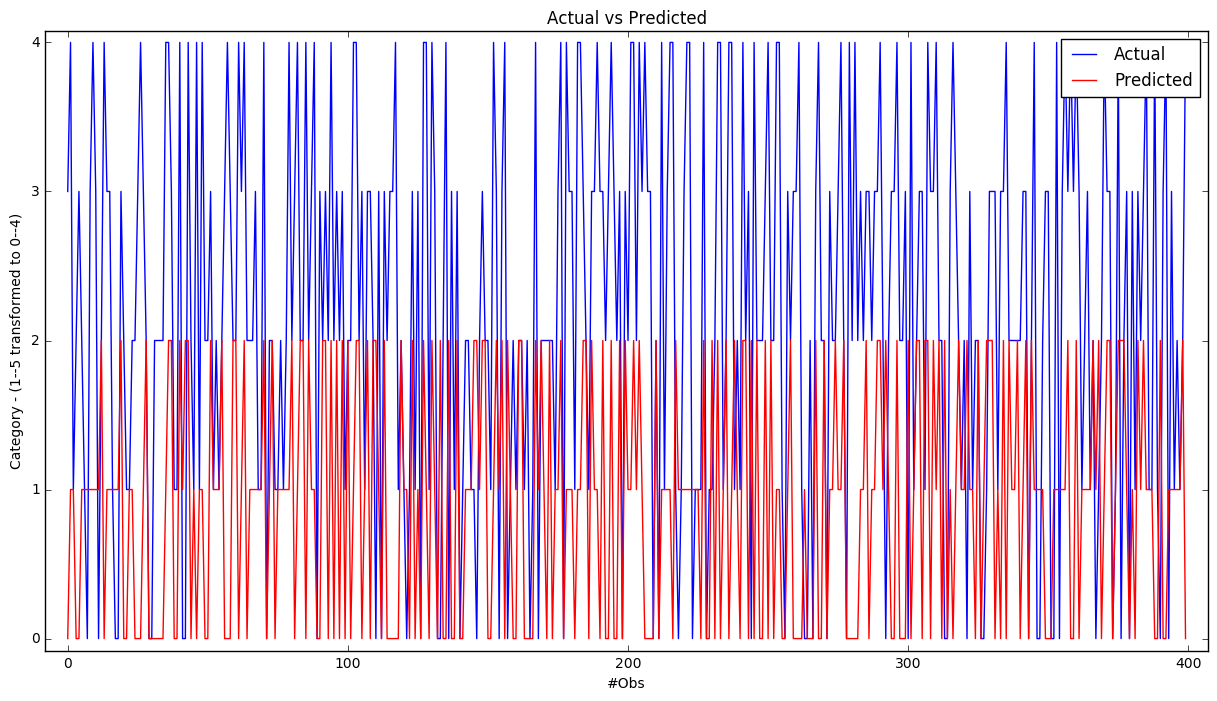

In [9]:
_ = plt.plot(test_mod, color='blue', label="Actual")
_ = plt.plot(test_predicted, color='red', label="Predicted")
plt.title("Actual vs Predicted")
plt.xlabel("#Obs")
plt.ylabel("Category - (1--5 transformed to 0--4)")
plt.margins(0.02)
plt.legend()
plt.show()

In [10]:
# Ref: http://stats.stackexchange.com/questions/110049/predict-observation-using-hidden-markov-models
# Ref: http://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.MultinomialHMM
# Ref: https://github.com/hmmlearn/hmmlearn/blob/master/hmmlearn/base.py
def get_fwd(index):
    most_prob = []
    model_hmm.fit(data_mod[:index])
    framelogprob = model_hmm._compute_log_likelihood(data_mod[:index])
    logprob, fwdlattice = model_hmm._do_forward_pass(framelogprob)
    alpha_i = max(fwdlattice[-1])
    i = list(fwdlattice[-1]).index(alpha_i)
    for y in range(len(observations)):
        sum = 0.0
        for j in states:
            a_ij = model_hmm.transmat_[i,j]
            b_jY = model_hmm.emissionprob_[j,y]
            sum += alpha_i + np.log(a_ij) + np.log(b_jY)
        most_prob.append(sum)
    return most_prob.index(max(most_prob))

In [11]:
predictions_new = [get_fwd(temp) for temp in range(len(train_mod), len(train_mod) + len(test_mod))]

In [12]:
print(predictions_new[:10])
print(test_mod[:10].T[0])
accuracy = np.sum(test_predicted == predictions_new)/400.0
print("Accuracy: %f" % accuracy)

[3, 3, 2, 4, 2, 2, 3, 2, 2, 3]
[3 4 1 2 3 2 1 0 3 4]
Accuracy: 0.172500


Here, we try to take a different approach for prediction. Using Brute-Force to infer the probabliities for next time-step, we see if this gives us any improvement.

We use the forward algorithm to calculate the joint probablity of observing the previous states and being in state i in next time step. Then we refer to A and B matrices for corresponding values of a_ij and b_jY, and calculate a sum over all possible states. We select the observation we predict as the one with the highest probability.

Even though this approach is mathematically correct, it gives us a poor accuracy, because we are predicting about observed states without getting to know anything about underlying hidden states. (We are practically using the 1600th state to predict for the next 400). Hence, the first few observations match, but then the accuracy decreases.

### Task 2 - How much into the future can I forecast?
The HMM model produces good results at the beginning, but then its accuracy declines as we go further away from the 1601st observation. You can observe this by doing a line plot of the actual vs the estimated results.

This can be resolved by retraining your HMM model. The question is how well your model can predict the n next estimates. If it can be good for n=10, for instance, then retrain your HMM every 10 observations using the entire set of data up to that point, or 1600 observations shifted to the point.

Vary n to find a good value. For each n calculate the sum of squared errors (SSE), the root mean squared error, and R2 obtained over the 400 hundred observations. Give your results in a table.

In [13]:
model_hmm1 = hmm.MultinomialHMM(n_components=len(states), tol=0.0001, n_iter=100)
model_hmm1.transmat_ = A
model_hmm1.emissionprob_ = B
model_hmm1.startprob_ = np.array(state_change_prob_eq)

In [14]:
def window_predict(index, window):
    train = data_mod[index+window-1600:index + window]
    test = data_mod[index + window: index + 2*window]
    model_hmm1.fit(train)
    _, posterior = model_hmm1.score_samples(train)
    lastprob = posterior[-1]
    model_hmm1.startprob_ = np.dot(lastprob, model_hmm1.transmat_)
    prediction, state = model_hmm1.sample(n_samples=window, random_state=7656)
    return prediction

In [15]:
test_len = len(test_mod)
total_sse, total_rmse, total_r2 = [], [], []
for window in range(2,10+1):
    prediction = np.array((0,1))
    itrns = int(test_len/window)
    last_itrn = test_len - itrns*window
    for i in range(itrns + 1):
        prediction =  np.append(prediction, window_predict(1600+i*window, window))
    model_hmm1.fit(data_mod[:1600 + itrns*window + window])
    last_pred, _ = model_hmm1.sample(n_samples=last_itrn, random_state=7656)
    prediction = np.append(prediction,last_pred)    
    sse, rmse, rsquare = get_errors(prediction[:test_len], test_mod)
    total_sse.append(sse)
    total_rmse.append(rmse)
    total_r2.append(rsquare)

In [16]:
window = list(range(2,10+1))
table_op = np.dstack((np.array(window), np.array(total_sse), np.array(total_rmse), np.array(total_r2)))

In [17]:
print(tabulate(table_op[0], headers=["Window Size", "SSE", "RMSE", "R_Squared"], tablefmt='orgtbl'))

|   Window Size |    SSE |    RMSE |   R_Squared |
|---------------+--------+---------+-------------|
|             2 | 566408 | 1.87816 |   -1.07634  |
|             3 | 615424 | 1.97611 |   -1.29855  |
|             4 | 544152 | 1.83507 |   -0.982165 |
|             5 | 619672 | 1.93455 |   -1.2029   |
|             6 | 559088 | 1.78466 |   -0.874742 |
|             7 | 545040 | 1.86548 |   -1.04838  |
|             8 | 556928 | 1.85876 |   -1.03367  |
|             9 | 532768 | 1.83576 |   -0.983636 |
|            10 | 556992 | 1.83439 |   -0.980693 |


From above table, we observe the minimum error (based on all three - SSE, RMSE, R^2) for window size of *7*.

Hence, keeping a window size of 7 will give us best results.

In [18]:
hmm_window = 7

### Task 3 - Extra credit
Use the forecasting models to model the data and compare them against your HMM model. The comparison will be based on the accuracy of predicting the test data, as measured by the statistical metrics.

In [19]:
train = list(data[:1600][0])
test = list(data[1600:][0])

In [20]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def calcSMA(data, window):
    weights = np.repeat(1.0, window)/window
    moving_avg = np.convolve(data, weights, 'valid')
    if window == 1:
        error = np.array(data[window:]) - np.array(moving_avg[:-1])
    else:
        error = np.array(data[window-1:]) - np.array(moving_avg)
    rmse = np.sqrt((error**2).mean())
    return error, rmse

In [21]:
ma_errors = []
ma_rmse = []
for m in range(1,100):
    error_temp, rmse_temp = calcSMA(train, m)
    ma_errors.append(error_temp)
    ma_rmse.append(rmse_temp)

In [22]:
best_m = ma_rmse.index(min(ma_rmse)) + 1
best_moving_avg = moving_average(train_mod, best_m)

In [23]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    return result

def es_res(x, alpha):
    exp_smooth = exponential_smoothing(x, alpha)
    rmse = math.sqrt(sm.mean_squared_error(x, exp_smooth))
    return exp_smooth, rmse

In [24]:
es_errors = []
es_rmse = []
step = 1/1000
for alpha in np.arange(0,1,step):
    error_temp, rmse_temp = es_res(train, alpha)
    es_errors.append(error_temp)
    es_rmse.append(rmse_temp)

In [25]:
best_alpha = es_rmse.index(min(es_rmse)) * step
best_exp_smooth = exponential_smoothing(train, best_alpha)

In [26]:
def auto_reg(data, p):
    ar_model = AR(data)
    ar_fit = ar_model.fit(p)
    ar_predict = ar_fit.predict(p)
    rmse = math.sqrt(sm.mean_squared_error(data[p:], ar_predict))
    return ar_model, ar_predict, rmse

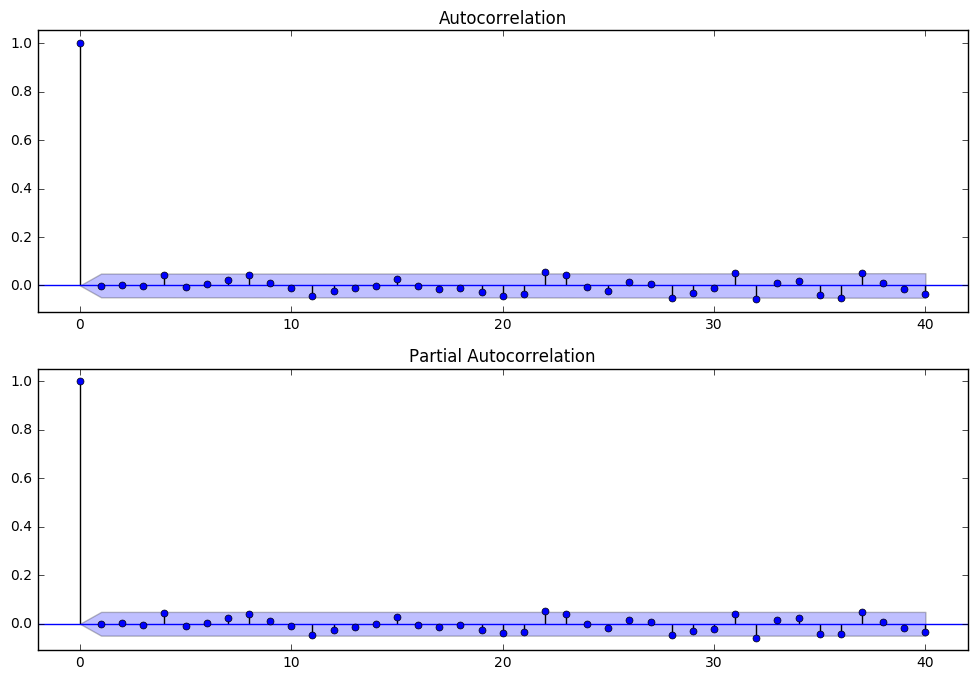

In [27]:
# Select p by plotting the partial autocorelation function.
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sta.graphics.tsa.plot_acf(train, lags = 40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sta.graphics.tsa.plot_pacf(train, lags = 40, ax=ax2)
plt.show()

In [28]:
best_p = 1
model_ar, predict_ar, rmse_ar = auto_reg(train, best_p)

In [29]:
test_ma_error, test_ma_rmse = calcSMA(test, best_m)
test_es_error, test_es_rmse = es_res(test, best_alpha)
test_ar_model, test_ar_predict, test_ar_rmse = auto_reg(test, best_p)

In [30]:
print(" --- Comparing HMM with other forecasting models --- \n")

print(tabulate([["Moving Average", test_ma_rmse, "Window = %d" % best_m], 
                ["Exponential Smoothing", test_es_rmse, "Alpha = %f" % best_alpha], 
                ["AutoRegression", test_ar_rmse, "Lag = %d" % best_p], 
                ["HMM", hmm_rmse, "Window = %d" % hmm_window]], 
               headers = ["Method", "RMSE", "Parameters"], tablefmt='orgtbl'))

 --- Comparing HMM with other forecasting models --- 

| Method                |    RMSE | Parameters       |
|-----------------------+---------+------------------|
| Moving Average        | 0.92209 | Window = 2       |
| Exponential Smoothing | 1.39787 | Alpha = 0.003000 |
| AutoRegression        | 1.30442 | Lag = 1          |
| HMM                   | 1.93843 | Window = 7       |


-------------------------------------------------------------------------------

### Conclusions

It is hard to solve HMM problem 3 directly without pertinent information. Even with randomness, it will take a long time to obtain the best values for A,B,Pi given data. With enough data points and iterations, we will be able to reach global maxima (or stationarity).

Using HMM for forecasting does not yield best results. After comparison with other forecasting methods (MA, ES, AR), we see that HMM performed the worst (with RMSE of 1.86) amongst them.

HMM has better uses in predicting the values of hidden states and understanding the latent structure of given model based on observations.